# Exercise 1:

### a)

y is the label of the response, which has value of -1 and 1.

At the beginning, The kernel logistic function can be presented as following, $f\in \mathcal{H}$ expanded by the kernel function k:

$$
\begin{aligned}
Objective\ &function:  \\
L &= \text{Negative Log-likelihood +Regularization} \\
&= -\sum^{N}_{i=1} log(1 + e^{-Y_i f(x_i)}) + \lambda {\left\Vert f\right\Vert} ^{2}\\
\end{aligned}
$$

Because this function is monotonic increasing with the increase of the norm of f. Thus, due to the representer theorem, f(x) can be represented by $\sum^{N}_{i=1} \alpha_i k(x_i, x)$, then we can rewrite the function as 

$$
\begin{aligned}
{\left\Vert f\right\Vert} ^{2} &= {\left\Vert\sum^{N}_{i=1} \alpha_i k(x_i, \cdot)\right\Vert}^{2}= \alpha^T K\alpha\\
f(x_i) &= \sum^{N}_{j=1} \alpha_j k(x_i, x_j) = (K\alpha)_i \\
Final\ Objective\ &function:\\
L &=  -\sum^{N}_{i=1} log(1 + e^{-Y_i (K\alpha)_i}) + \lambda \alpha^T K\alpha\\
\end{aligned}
$$

Which is the form we want here.

# b)

F is obvious differentable with smooth functions like logarithm and exponential. We shall first derive the formula for gradient of F.

$$
\begin{aligned}
\frac{\partial{F}}{\partial{\alpha}} &=  -\sum^{N}_{i=1} \frac{1}{1 + e^{-Y_i (K\alpha)_i})} 
\frac{\partial{(1 + e^{-Y_i(K\alpha)_i})}}{\partial{\alpha}} + 2\lambda K\alpha\\ 
& = -\sum^{N}_{i=1} \frac{-e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})} 
\frac{\partial{(Y_i(K\alpha)_i)}}{\partial{\alpha}} + 2\lambda K\alpha\\
& = \sum^{N}_{i=1} \frac{e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})} 
Y_iK_i + 2\lambda K\alpha
\end{aligned}
$$

In the former part of the gradient, the 


The latter part is linear in $\alpha$. So it is L-smooth with some sufficient large L.

In the former part of the gradient, the $Y_iK_i$ is constant vector, while $\frac{e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})}$ has bounded gradient:

$$
\begin{aligned}
\frac{\partial{\frac{e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})}}}{\partial \alpha} = 
\frac{-e^{-Y_i(K\alpha)_i}}{(1 + e^{-Y_i (K\alpha)_i})^2} *Y_i K_i
\end{aligned}
$$

With ease we can find this is a vector with the elements whose absolute value's uniformly lower than $\frac{1}{4}max(K_i)$. Then we can apply mean value theorem and cauchy schwarz inequality to find a suitable L for our problem.

$$
\begin{aligned}
\left\vert \nabla F(\alpha_1) -\nabla F(\alpha_2) \right\vert &\leq \sum^{N}_{i=1} \frac{1}{4}max(K_i) \left\vert \alpha_1 -\alpha_2 \right\vert + 2\lambda \left\vert K \right\vert \left\vert \alpha_1 -\alpha_2 \right\vert \\
&\leq (\frac{n}{4}max(K) +  2\lambda \left\vert K \right\vert) \left\vert \alpha_1 -\alpha_2 \right\vert 
\end{aligned}
$$

where $max(K)$ is the biggest element in the gram matrix. This is can be regarded as a reasonable L. Thus we have that this function is L smooth.

### c)

I will still use LFW dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

lfw = fetch_lfw_people(min_faces_per_person=70)
mask = np.isin(lfw.target, [3, 4])
X= lfw.data[mask]
y= lfw.target[mask]
y[y==3]=1
y[y==4]=-1


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1209)

### d)

For the stepsize, $\frac{1}{L}$ is a reasonable start point.

In [2]:
lambd = 0.01

def RBF(x,y, sigma = 1):
    return np.exp(- np.linalg.norm(x-y)**2/(2*sigma))

def loss_function(GRAM, alpha,N):

    
    temp1 = np.dot(GRAM, alpha)
    L = - np.sum(np.log(1 + np.exp(- temp1* y_train.reshape(N,1))))
    L += lambd * np.dot(np.dot(alpha.T, GRAM), alpha)
    return L

def mysvm_grad(eps= 1e-4, alpha_search= 0.5, beta= 0.5):
    N = len(X_train)
    GRAM = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            GRAM[i,j] = RBF(X[i],X[j])
    eta =1/(N/4 * np.amax(GRAM) +2*lambd*np.linalg.det(GRAM))
    print("Initial learning rate is ", eta)
    
    alpha = np.random.randn(N).reshape(N,1)
    diff = 1000
    count = 0
    while(np.abs(diff) > eps):
        temp1 = np.dot(GRAM, alpha)
        coeff = 1- 1/(1 + np.exp(- temp1* y_train.reshape(N,1)))
        grad = np.dot(GRAM,coeff* y_train.reshape(N,1))
        grad += 2* lambd * temp1
        
        #search for another step size
        eta1 = eta
        L= loss_function(GRAM, alpha, N)
        L_new =loss_function(GRAM, alpha- eta1* grad, N) 
        while(L_new>= L- alpha_search*eta1* np.sum(grad*grad)):
            eta1 *= beta
            L_new =loss_function(GRAM, alpha- eta1* grad, N) 
    
        alpha -= eta1 * grad
        print('Round %d' % count)
        count += 1
        diff = L_new - L
        print('Difference now is %f' %diff)
    return alpha

In [ ]:
alpha = mysvm_grad()
# np.amax(X_train)
# y_train.shapep

In [40]:
alpha

array([[-4.94202595],
       [-4.96184953],
       [-4.96107051],
       [-4.96182305],
       [-4.91996295],
       [-4.96666966],
       [-4.96869736],
       [-4.96650226],
       [-4.96849183],
       [-4.94027249],
       [-4.95707789],
       [-4.92643119],
       [-4.95572808],
       [-4.95274175],
       [-4.95941483],
       [-4.95055444],
       [-4.94719462],
       [ 4.95388662],
       [-4.95737762],
       [-4.95615377],
       [-4.96758145],
       [ 4.92735313],
       [-4.95656592],
       [-4.96038704],
       [-4.96363083],
       [-4.94308188],
       [-4.96748706],
       [-4.96968611],
       [-4.91978153],
       [-4.95348665],
       [-4.96350146],
       [-4.95037437],
       [ 4.95060161],
       [-4.9621114 ],
       [-4.93065486],
       [-4.96333127],
       [-4.91699393],
       [-4.90706875],
       [-4.93292842],
       [ 4.96499568],
       [ 4.94869446],
       [-4.95995506],
       [-4.92985928],
       [-4.94667933],
       [-4.94582813],
       [-4

# Exercise 2:

$$
\begin{aligned}
X = \begin{bmatrix}
    x_{11} &x_{12} & \dots  x_{1p} \\
    \dots \\
    x_{n1} &x_{n2} & \dots  x_{np} \\
\end{bmatrix}\
Z^{(1)} = \begin{bmatrix}
    z_{11} &z_{12} & \dots  z_{1M} \\
    \dots \\
    z_{n1} &z_{n2} & \dots  z_{nM} \\
\end{bmatrix}\   
Z^{(2)} = \begin{bmatrix}
    z_{11} &z_{12} & \dots  z_{1K} \\
    \dots \\
    z_{n1} &z_{n2} & \dots  z_{nK} \\
\end{bmatrix}\   
Y = \begin{bmatrix}
    y_{11} &y_{12} & \dots  y_{1K} \\
    \dots \\
    y_{n1} &y_{n2} & \dots  y_{nK} \\
\end{bmatrix}
\end{aligned}
$$

The size of the parameter matrices are not explicitly represented here. They should be conformable to the hidden units and X. 

### Forward Propagation:


$$
\begin{aligned}
Z^{(1)} &= X\beta^{(1)} + \alpha^{(1)}\\
A^{(1)} &=  \sigma^{(1)}(Z^{(1)}) \\
Z^{(2)} &=  A^{(1)}\beta^{(2)} + \alpha^{(2)} \\
\hat{Y} &= softmax(Z^{(2)}) \\
R &= -\sum^{n}_{i=1} \sum^{K}_{k=1} Y_{ik}log{\hat{Y}_{ik}} \\
\end{aligned}
$$

### Back Propagation:

In the back propagation, I will assume the $\sigma^{(2)}$ is the softmax function, and then the $\sum^{K}_{k=1}Z^{(2)}_{ik} = 1$.
$$
\begin{aligned}
\frac{\partial{R}}{\partial{Z^{(2)}_{ij} }} &= \hat{Y}_{ij} - Y_{ij} \\
\frac{\partial{R}}{\partial{Z^{(2)}}} &= \hat{Y} - Y \\
\frac{\partial{R}}{\partial{\beta^{(2)}}} &= {A^{(1)}}^T \frac{\partial{R}}{\partial{Z^{(2)}}}\\
\frac{\partial{R}}{\partial{\alpha^{(2)}}} &= {\mathbf{1}}^T \frac{\partial{R}}{\partial{Z^{(2)}}} \\
\frac{\partial{R}}{\partial{A^{(1)}}} &= \frac{\partial{R}}{\partial{Z^{(2)}}}  {\beta^{(2)}} ^T \\
\frac{\partial{R}}{\partial{Z^{(1)}}} &= \frac{\partial{R}}{\partial{A^{(1)}}} \circ \frac{\partial{A^{(1)}}}{\partial{Z^{(1)}}}\ \ \ where \frac{\partial{A^{(1)}}}{\partial{Z^{(1)}}} = (\frac{\partial{A^{(1)}_{ij}}}{\partial{Z^{(1)}_{ij}}})_{i,j}  \\ 
\frac{\partial{R}}{\partial{\beta^{(1)}}} &= {X}^T \frac{\partial{R}}{\partial{Z^{(1)}}}\\
\frac{\partial{R}}{\partial{\alpha^{(1)}}} &= {\mathbf{1}}^T \frac{\partial{R}}{\partial{Z^{(1)}}} \\
\end{aligned}
$$

# Exercise 3

### a)

In [53]:
import numpy as np
import matplotlib.pyplot as plt


class MY_NN(object):

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        loss = 0.0
        scores = None
        H1 = np.dot(X, W1) + b1.reshape(1,-1)
        A1 = np.maximum(H1, 0)
        H2 = np.dot(A1,W2) + b2.reshape(1,-1) #shape(N, H2)
        scores= H2

        if y is None:
            return scores


        loss = np.sum((H2 - y)**2 / N)
        loss += reg * (np.sum(W2**2) + np.sum(W1**2))

        grads = {}
        dZ2 = (H2 - y) * 2 / N

        dW2 =  np.dot(A1.T, dZ2) + 2 * reg* W2 #should be a (H,C) matrix
        db2 =  dZ2.sum(axis=0,)

        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * (A1 >0)
        dW1 =  np.dot(X.T, dZ1) + 2 * reg* W1
        db1 = dZ1.sum(axis=0,)
        grads['W1'] =dW1
        grads['W2'] =dW2
        grads['b1'] =db1
        grads['b2'] =db2

        return loss, grads

    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3,
            reg=5e-6, num_iters=200, verbose=False):
        num_train = X.shape[0]
        num_val = X_val.shape[0]

        loss_history = []
        val_loss_history = []

        for it in range(num_iters):
            loss, grads = self.loss(X, y=y, reg=reg)
            loss_history.append(loss)
            for param in self.params:
                self.params[param] -= learning_rate* grads[param]

            val_loss = np.sum((self.predict(X_val)- y_val)**2 /num_val)
            val_loss_history.append(val_loss)
            #learning_rate *= 0.99
        
        return {
          'loss_history': loss_history,
          'val_loss_history': val_loss_history,
        }

    def predict(self, X):
        y_pred = None
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        H1 = np.dot(X, W1) + b1.reshape(1,-1)
        A1 = np.maximum(H1, 0)
        H2 = np.dot(A1,W2) + b2.reshape(1,-1) #shape(N, H2)
        return H2

In [11]:
def sigmoid(x):
    return 1/(1+ np.exp(-x))

X = np.random.randn(1100,2)
Z = np.random.randn(1100).reshape(1100,1)
a1 = np.array([3,3]).reshape(2,1)
a2 = np.array([3,-3]).reshape(2,1)
Y = sigmoid(np.dot(X, a1)) + (np.dot(X, a2)**2) + 0.3 * Z

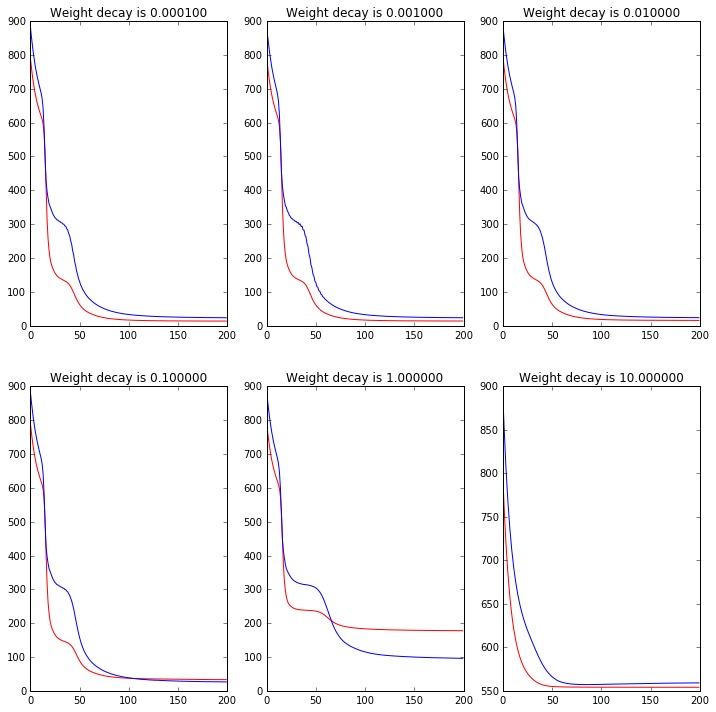

In [46]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


gs = gridspec.GridSpec(2,3)
fig = plt.figure(figsize= (12,12))

wd_list = 10 **np.linspace(-4,1,num=6)

for num,wd in enumerate(wd_list):
    Net = MY_NN(2,10,1)
    result =Net.train(X[0:100,], Y[0:100,],X[100:1100,],Y[100:1100,], learning_rate=0.03, reg= wd)
    
    fig1 = fig.add_subplot(gs[int(num/3), num%3])
    fig1.plot(result['loss_history'] ,color='r', label='train loss')
    fig1.plot(result['val_loss_history'],color='b', label='val loss')
    fig1.set(title= "Weight decay is %f" %wd )

### b)

The result above indicates that this regression problem is quite easy for the Two layer neural network. When the weight decay is around 0.001, the val error is pretty low. The overfitting is not quite obvious. But if we set weight decay too large, the capacity of model is insufficient to fit this model. So the loss is high in train and val.

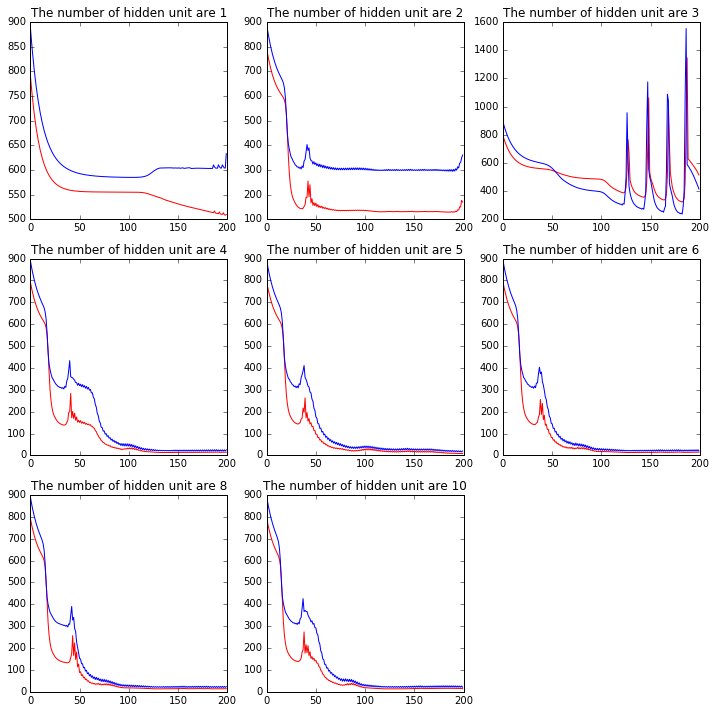

In [54]:
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize= (12,12))

hid_list = [1,2,3,4,5,6,8,10]

for num,hid in enumerate(hid_list):
    Net = MY_NN(2,hid,1)
    result =Net.train(X[0:100,], Y[0:100,],X[100:1100,],Y[100:1100,], learning_rate=0.025, reg= 0.001)
    
    fig1 = fig.add_subplot(gs[int(num/3), num%3])
    fig1.plot(result['loss_history'] ,color='r', label='train loss')
    fig1.plot(result['val_loss_history'],color='b', label='val loss')
    fig1.set(title= "The number of hidden unit are %d" % hid)

### c)

When the number of hidden units are over 4. The performance is competitive with the 10-hidden-unit version.